In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import cftime
from glob import glob
import cmocean

# Parameters for the C budget
c_2_n = 106 / 16
carbon_molar_weight = 12
seconds_per_year = 24*60*60*365

## Generate paths

In [2]:
# pp path
pp_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20241211/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/'

In [3]:
grid_file = pp_path + 'ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [4]:
# carbon vertical integral 
diag_type = 'ocean_cobalt_tracers_instant'
variable = 'wc_vert_int_c'

total_vertint_files = glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + variable + '.nc')

In [5]:
# carbon flux files
# surface fluxes
diag_type = 'ocean_cobalt_sfc'
variables = ['dic_stf_gas','runoff_flux_dic','runoff_flux_ldon','runoff_flux_sldon','runoff_flux_srdon','runoff_flux_ndet']

surf_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
surf_files = sorted([f for fi in surf_files for f in fi]) # nested list comprehension

In [6]:
# carbon flux files
# bottom fluxes
diag_type = 'ocean_cobalt_btm'
variables = ['fcased_redis','fcadet_calc_btm','fn_burial']

btm_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
btm_files = sorted([f for fi in btm_files for f in fi]) # nested list comprehension

## Read in files

In [7]:
total = xr.open_mfdataset(total_vertint_files, combine='by_coords')

In [8]:
surf = xr.open_mfdataset(surf_files, combine='by_coords')

In [9]:
btm = xr.open_mfdataset(btm_files, combine='by_coords')

In [10]:
# # temporarily read in files
# history_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20241211/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/history/OLD/'
# total = xr.open_dataset(history_path + '00040101.ocean_cobalt_tracers_instant.nc')
# surf = xr.open_dataset(history_path + '00040101.ocean_cobalt_sfc.nc')
# btm = xr.open_dataset(history_path + '00040101.ocean_cobalt_btm.nc')
# grid = xr.open_dataset(history_path + '00040101.ocean_static.nc')

## Compute Global Inventory

These values are from ocean_cobalt_tracer_instant and are written out at the end of the year

In [11]:
global_total = (total.wc_vert_int_c * grid.areacello).sum(dim=['xh','yh']) * carbon_molar_weight

Text(0.5, 1.0, 'Global carbon inventory (Eg)')

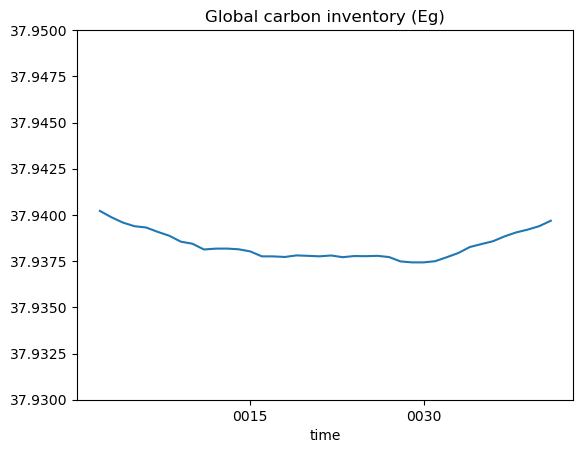

In [12]:
(global_total/1e18).plot()
plt.ylim(37.93,37.95)
plt.title('Global carbon inventory (Eg)')

## Compute Fluxes

In [13]:
total_runoff = surf.runoff_flux_dic + \
               surf.runoff_flux_ldon * c_2_n + \
               surf.runoff_flux_sldon * c_2_n + \
               surf.runoff_flux_srdon * c_2_n + \
               surf.runoff_flux_ndet * c_2_n

total_runoff = (total_runoff * grid.areacello).sum(dim=['xh','yh'])
total_runoff = total_runoff * carbon_molar_weight * seconds_per_year

In [14]:
dic_stf_gas = (surf.dic_stf_gas * grid.areacello).sum(dim=['xh','yh'])
dic_stf_gas = dic_stf_gas * carbon_molar_weight * seconds_per_year

In [15]:
net_calcite = btm.fcased_redis - btm.fcadet_calc_btm 
net_calcite = (net_calcite * grid.areacello).sum(dim=['xh','yh'])
net_calcite = net_calcite * carbon_molar_weight * seconds_per_year

In [16]:
burial = (btm.fn_burial * grid.areacello).sum(dim=['xh','yh']) * c_2_n
burial = burial * carbon_molar_weight * seconds_per_year

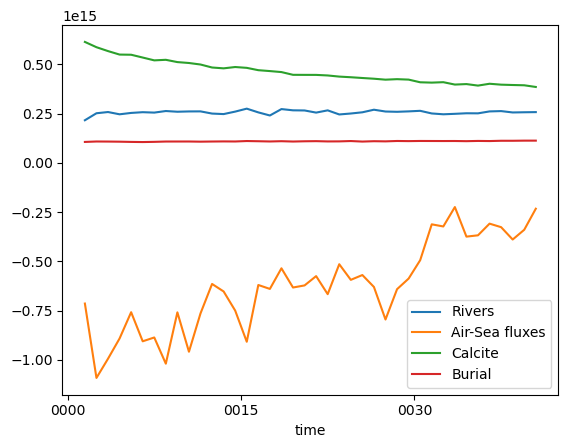

In [17]:
total_runoff.plot()
dic_stf_gas.plot()
net_calcite.plot()
burial.plot()
plt.legend(['Rivers','Air-Sea fluxes','Calcite','Burial'])

Text(0.5, 1.0, 'Net carbon fluxes (grams)')

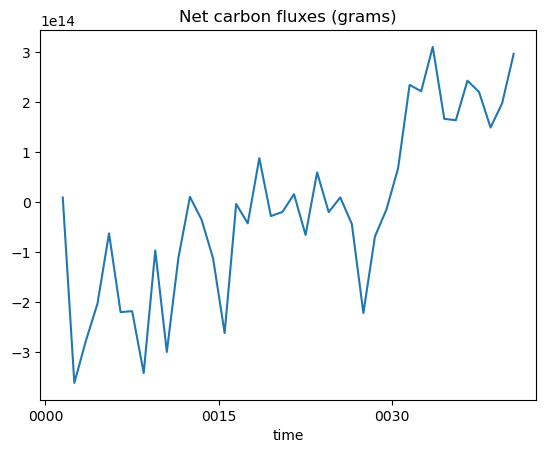

In [18]:
net_flux = total_runoff + dic_stf_gas + net_calcite - burial
net_flux.plot()
plt.title('Net carbon fluxes (grams)')

## Close budgets
The total carbon inventory should be equal to the starting inventory plus the carbon fluxes
In this case we start with year 2 and onwards, because the wc_vert_int_c term is saved at the end of year 1

Text(0.5, 1.0, 'Carbon fluxes as calculated by the change in the global C inventory')

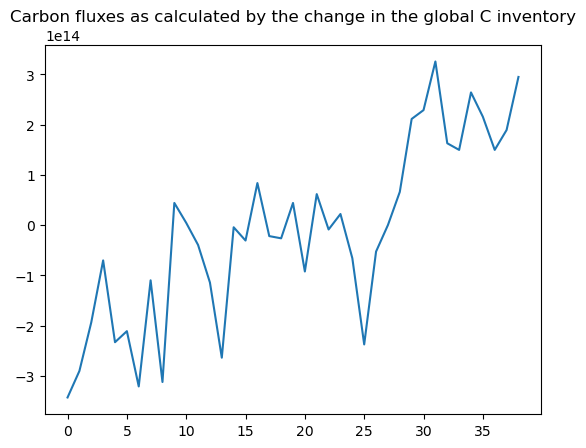

In [19]:
plt.plot(np.diff(global_total))
plt.title('Carbon fluxes as calculated by the change in the global C inventory')

In [20]:
np.diff(global_total.values)

array([-3.4304763e+14, -2.9027107e+14, -1.9351405e+14, -7.0368744e+13,
       -2.3309647e+14, -2.1110623e+14, -3.2105740e+14, -1.0995116e+14,
       -3.1226130e+14,  4.3980465e+13,  4.3980465e+12, -3.9582419e+13,
       -1.1434921e+14, -2.6388279e+14, -4.3980465e+12, -3.0786326e+13,
        8.3562884e+13, -2.1990233e+13, -2.6388279e+13,  4.3980465e+13,
       -9.2358977e+13,  6.1572651e+13, -8.7960930e+12,  2.1990233e+13,
       -6.5970698e+13, -2.3749451e+14, -5.2776558e+13,  0.0000000e+00,
        6.5970698e+13,  2.1110623e+14,  2.2869842e+14,  3.2545544e+14,
        1.6272772e+14,  1.4953358e+14,  2.6388279e+14,  2.1550428e+14,
        1.4953358e+14,  1.8911600e+14,  2.9466912e+14], dtype=float32)

In [21]:
net_flux.values[1:]

array([-3.61154908e+14, -2.76917159e+14, -2.02799320e+14, -6.21991072e+13,
       -2.19571757e+14, -2.17645862e+14, -3.41321421e+14, -9.62554722e+13,
       -2.99159097e+14, -1.11259024e+14,  1.10776744e+13, -3.44771814e+13,
       -1.11932459e+14, -2.61423009e+14, -3.20221274e+12, -4.21412572e+13,
        8.84221663e+13, -2.75219875e+13, -1.92046356e+13,  1.63433112e+13,
       -6.52209892e+13,  5.98936206e+13, -1.95328544e+13,  9.77678284e+12,
       -4.31787758e+13, -2.21362545e+14, -6.83342389e+13, -1.40245165e+13,
        6.78335260e+13,  2.34883991e+14,  2.22169417e+14,  3.10801574e+14,
        1.66913520e+14,  1.64250541e+14,  2.43210339e+14,  2.20892461e+14,
        1.49620802e+14,  1.98038354e+14,  2.96969640e+14])

Text(0.5, 1.0, 'Global carbon inventory (Eg)')

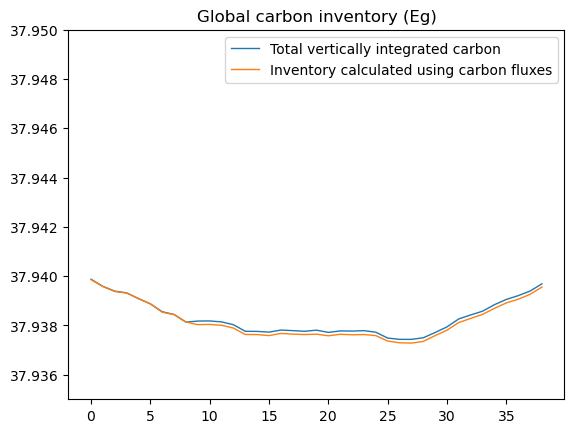

In [22]:
plt.plot(global_total.values[1:]/1e18, linewidth=1)
plt.plot((np.cumsum(net_flux.values[1:])+global_total.values[0])/1e18, linewidth=1)
plt.ylim(37.935,37.95)
plt.legend(['Total vertically integrated carbon','Inventory calculated using carbon fluxes'])
plt.title('Global carbon inventory (Eg)')

Text(0.5, 1.0, 'Total global carbon inventory imbalance')

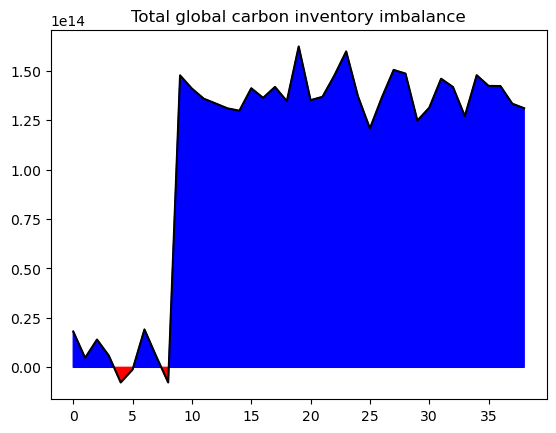

In [23]:
fig,ax = plt.subplots(1,1)
imbalance=(global_total.values[1:] - (np.cumsum(net_flux.values[1:])+global_total.values[0]))
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global carbon inventory imbalance')

Text(0.5, 1.0, 'Total global carbon flux imbalance')

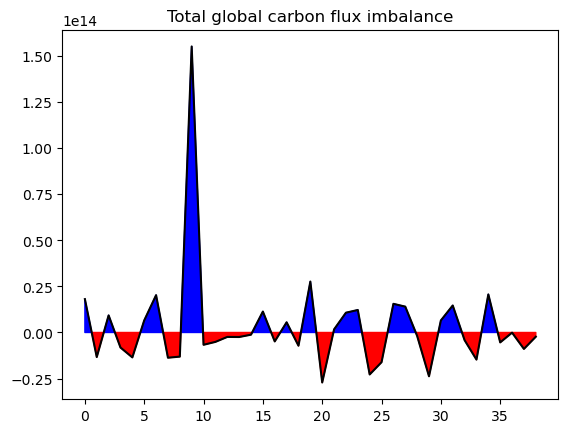

In [24]:
fig,ax = plt.subplots(1,1)
imbalance=(np.diff(global_total.values) - net_flux.values[1:])
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global carbon flux imbalance')